In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-resized/trainLabels.csv
/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/81_right.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/17169_left.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/38111_right.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/23964_left.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/13170_left.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/23309_left.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/18069_right.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/40447_right.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/29064_right.jpeg
/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/12589_left.jpeg
/k

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define image directory and label file paths
image_dir = "/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
label_file = "/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"


In [ ]:

# Load label data
labels_df = pd.read_csv(label_file)

# Group the labels by level and sample 400 samples from each level
labels_grouped = labels_df.groupby('level').apply(lambda x: x.sample(min(300, len(x))))

# Define data augmentation for level 0 images
data_augmentation = ImageDataGenerator(
    rotation_range=45,  # Random rotation up to 45 degrees
    width_shift_range=0.3,  # Random width shift
    height_shift_range=0.3,  # Random height shift
    shear_range=0.3,  # Shear intensity
    zoom_range=0.3,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for new pixels
)

In [ ]:
import pandas as pd

# Assuming labels_grouped is already defined

# Calculate the number of images for each level after sampling
grouped_counts = labels_grouped['level'].value_counts().sort_index()

# Convert the counts to a DataFrame
counts_df = pd.DataFrame(grouped_counts).reset_index()
counts_df.columns = ['Level', 'Number of Images']

# Print the DataFrame as a table
print(counts_df)

In [7]:
# Load and preprocess images with data augmentation
images = []
labels = []
for index, row in labels_grouped.iterrows():
    image_path = os.path.join(image_dir, f"{row['image']}.jpeg")
    img = Image.open(image_path)
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    
    # Apply data augmentation for level 0 images
    if row['level'] == 0:
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for flow method
        for _ in range(10):  # Augment 10 additional images for level 0
            for batch in data_augmentation.flow(img_array, batch_size=1):
                augmented_img = batch[0]
                images.append(augmented_img)
                labels.append(row['level'])
                break  # Break after one iteration to avoid infinite loop
    else:
        images.append(img_array)
        labels.append(row['level'])

images = np.array(images)
labels = np.array(labels)

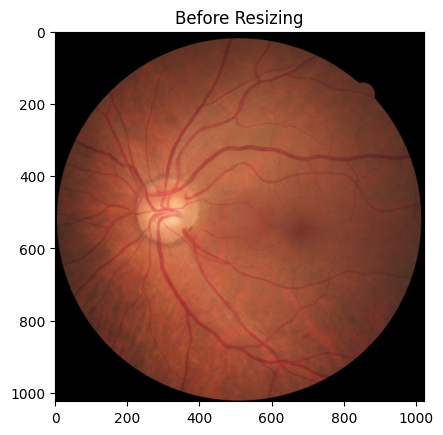

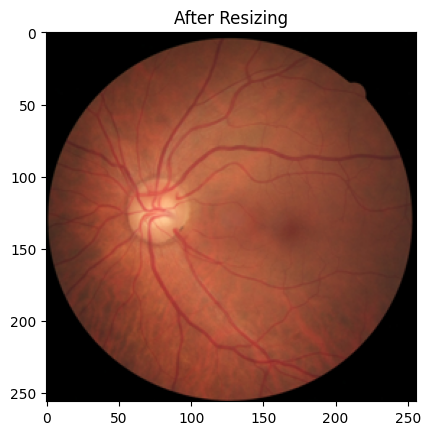

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Assuming labels_grouped DataFrame and image_dir are already defined

# Select one specific image (e.g., the first image in the DataFrame)
row = labels_grouped.iloc[0]
image_path = os.path.join(image_dir, f"{row['image']}.jpeg")
img = Image.open(image_path)

# Show image before resizing
plt.figure()
plt.title("Before Resizing")
plt.imshow(img)
plt.show()

# Resize the image
img_resized = img.resize((256, 256))

# Show image after resizing
plt.figure()
plt.title("After Resizing")
plt.imshow(img_resized)
plt.show()


In [9]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Unfreeze some top layers for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom classifier layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(5, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with lower learning rate
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Train model with more epochs
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Extract features using the trained model
features_train = model.predict(X_train)
features_test = model.predict(X_test)

Epoch 1/30


2024-05-21 17:00:23.821498: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-21 17:00:23.825550: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-05-21 17:00:23.825592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-05-21 17:00:23.825610: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-05-21 17:00:23.825629: E external/local_xla/xla/service/gpu/buffer_comparato

 1/84 ━━━━━━━━━━━━━━━━━━━━ 39:40 29s/step - accuracy: 0.0625 - loss: 2.7078

I0000 00:00:1716310847.416145     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.6604 - loss: 2.1605 - val_accuracy: 0.7574 - val_loss: 0.6168
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7938 - loss: 0.4889 - val_accuracy: 0.7485 - val_loss: 0.5264
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7805 - loss: 0.4759 - val_accuracy: 0.7991 - val_loss: 0.4634
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7899 - loss: 0.4268 - val_accuracy: 0.7812 - val_loss: 0.4682
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7779 - loss: 0.4414 - val_accuracy: 0.7887 - val_loss: 0.4741
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8027 - loss: 0.4157 - val_accuracy: 0.7932 - val_loss: 0.4745
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8069 - loss: 0.4136 - val_accuracy: 0.7976 - val_loss: 0.4843
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8085 - loss: 0.3829 - val_accuracy: 0.808

2024-05-21 17:06:04.602202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-05-21 17:06:04.602290: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-05-21 17:06:04.602306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-05-21 17:06:04.602315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-05-21 17:06:04.602342: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.90088, expected 6.06975
2024-05-21 17:06:04.602350: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.70007, expected 5.86894
2024-05-21 17:06:04.602359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.75339, expected 4.92226
2024-05-21 17:06:04.602368: E external/local_xla/xla/ser

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step


In [11]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("ImageClassification") \
    .getOrCreate()

# Create Spark DataFrame for train and test data
train_df = pd.DataFrame(features_train)
train_df['label'] = y_train
train_spark_df = spark.createDataFrame(train_df)

test_df = pd.DataFrame(features_test)
test_df['label'] = y_test
test_spark_df = spark.createDataFrame(test_df)

# Define vector assembler
assembler = VectorAssembler(inputCols=train_spark_df.columns[:-1], outputCol='features')

# Transform train and test data
train_spark_df = assembler.transform(train_spark_df)
test_spark_df = assembler.transform(test_spark_df)

# Define MLP model with tuned hyperparameters
layers = [train_spark_df.schema['features'].metadata["ml_attr"]["num_attrs"], 256, 128, 64, 5]
mlp = MultilayerPerceptronClassifier(layers=layers, seed=42, blockSize=128, maxIter=100, stepSize=0.03)

# Train MLP model with more iterations
mlp_model = mlp.fit(train_spark_df)

# Make predictions
predictions = mlp_model.transform(test_spark_df)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

# Print the number of images
print("Number of images:", len(images))


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/21 17:06:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/21 17:06:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Test Accuracy: 0.8261904761904761
Number of images: 4200


In [12]:
# Make predictions on the training set
train_predictions = mlp_model.transform(train_spark_df)

# Evaluate train accuracy
train_accuracy = evaluator.evaluate(train_predictions)
print("Train Accuracy:",train_accuracy)

Train Accuracy: 0.9047619047619048


In [13]:
import pandas as pd

# Convert labels array to a DataFrame for easier manipulation
labels_df = pd.DataFrame({'Level': labels})

# Count the number of images for each level
grouped_counts = labels_df['Level'].value_counts().sort_index()

# Convert the counts to a DataFrame
counts_df = pd.DataFrame(grouped_counts).reset_index()
counts_df.columns = ['Level', 'Number of Images']

# Print the DataFrame as a table
print(counts_df)


   Level  Number of Images
0      0              3000
1      1               300
2      2               300
3      3               300
4      4               300


In [14]:
# Assuming 'features_train' and 'features_test' are the arrays containing extracted features

num_features_train = features_train.shape[1]  # Number of features in the training set
num_features_test = features_test.shape[1]    # Number of features in the testing set

print("Number of features in the training set:", num_features_train)
print("Number of features in the testing set:", num_features_test)

Number of features in the training set: 5
Number of features in the testing set: 5


In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ImageClassification") \
    .getOrCreate()

# Convert training and testing data to Pandas DataFrames
train_df = pd.DataFrame(features_train)
train_df['label'] = y_train

test_df = pd.DataFrame(features_test)
test_df['label'] = y_test

# Create Spark DataFrames from Pandas DataFrames
train_spark_df = spark.createDataFrame(train_df)
test_spark_df = spark.createDataFrame(test_df)

# Define VectorAssembler
assembler = VectorAssembler(inputCols=train_spark_df.columns[:-1], outputCol='features')

# Transform train and test data
train_spark_df = assembler.transform(train_spark_df)
test_spark_df = assembler.transform(test_spark_df)

# Define MLP model with tuned hyperparameters
layers = [train_spark_df.schema['features'].metadata["ml_attr"]["num_attrs"], 256, 128, 64, 5]
mlp = MultilayerPerceptronClassifier(layers=layers, seed=42, blockSize=128, maxIter=100, stepSize=0.03)

# Train MLP model
mlp_model = mlp.fit(train_spark_df)

# Make predictions
predictions = mlp_model.transform(test_spark_df)

# Evaluate model accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

# Extract predictions and labels
predictions_df = predictions.select("label", "prediction").toPandas()

# Calculate confusion matrix
conf_matrix = confusion_matrix(predictions_df['label'], predictions_df['prediction'])

# Calculate classification report
class_report = classification_report(predictions_df['label'], predictions_df['prediction'])

# Calculate precision, recall, and F1-score for each class
precision, recall, fscore, support = precision_recall_fscore_support(predictions_df['label'], predictions_df['prediction'])

# Create a dictionary to store precision and recall for each class
precision_recall_dict = {
    "Class": np.arange(len(precision)),  # Class labels
    "Precision": precision,
    "Recall": recall
}

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Print precision and recall for each class
print("\nPrecision and Recall for Each Class:")
precision_recall_table = pd.DataFrame(precision_recall_dict)
print(precision_recall_table)


Test Accuracy: 0.8261904761904761
Confusion Matrix:
[[616   2   1   2   0]
 [  1  21  17   9   2]
 [  0  17  21  10   3]
 [  0  10  28  12  15]
 [  1   6  13   9  24]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       621
           1       0.38      0.42      0.40        50
           2       0.26      0.41      0.32        51
           3       0.29      0.18      0.22        65
           4       0.55      0.45      0.49        53

    accuracy                           0.83       840
   macro avg       0.49      0.49      0.49       840
weighted avg       0.83      0.83      0.83       840


Precision and Recall for Each Class:
   Class  Precision    Recall
0      0   0.996764  0.991948
1      1   0.375000  0.420000
2      2   0.262500  0.411765
3      3   0.285714  0.184615
4      4   0.545455  0.452830


In [16]:
pip install scikit-learn pandas pyspark


Note: you may need to restart the kernel to use updated packages.
